# Random Forest Classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns

from sklearn.pipeline import make_pipeline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

NUMBER_SEED = 1

In [3]:
df = pd.read_csv(data)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preparation

In [5]:
# drop customerID column
df = df.drop('customerID', axis=1)

In [6]:
# replace column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# replace categorical column values to lowercase and replace spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [8]:
# convert totalcharges to numeric
# parameter errors='coerce' will replace non-numeric values with NaN
#           errors='raise' (default) if any invalid value, it will raise an exception
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [9]:
# check for missing values
df.isna().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [10]:
# all columns except totalcharges have no missing values
# fill na with 0 in column totalcharges
df.totalcharges = df.totalcharges.fillna(0)

In [11]:
# target value is churn column
# change churn to number, 1 if yes, 0 if no
df.churn = (df.churn == 'yes').astype(int)

In [12]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

## Split Data

In [13]:
# split data into train, val and test 60%, 20%, 20%

# test size 20%
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=NUMBER_SEED,
    stratify=df.churn
)

# val 25% of the remaining 80% = 20%
# train is remaining 60%
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=NUMBER_SEED,
    stratify=df_full_train.churn
)

In [14]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
# separate target value and remove it from dataframes
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [16]:
# vectorize dataframes
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

## Train

In [17]:
dt = RandomForestClassifier(random_state=NUMBER_SEED)
dt.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

In [18]:

def train_rf(xt, yt, n_estimators=100, max_depth=1, class_weight=None):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                random_state=NUMBER_SEED, n_jobs=-1,
                                class_weight=class_weight)
    rf.fit(xt, yt)

    return rf


In [19]:
arr_max_depth = [1,2,3,4,5, 6, 7, 8]

metric_results = []

for max_depth in arr_max_depth:
    rf = train_rf(X_train, y_train, max_depth=max_depth)

    y_val_pred = rf.predict_proba(X_val)[:, 1]
    #print(y_val_pred)
    y_val_pred_th = (y_val_pred >= 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred_th)
    #print(f'max_depth={max_depth} accuracy={accuracy}')

    cf = confusion_matrix(y_val, y_val_pred_th)
    tn, fp, fn, tp = cf.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # true negative rate (specificity)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # false negative rate (miss rate)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    #print(f'precision={precision}')
    #print(f'recall={recall}')
    #print(f'true_positive_rate={recall}')
    #print(f'true_negative_rate={tnr}')
    #print(f'f1={f1}')

    auc_score = roc_auc_score(y_val, y_val_pred)
    #print(f'max_depth={max_depth} auc={auc_score}')

    #print('---')
    #print('')

    # Store metrics in dictionary
    metrics = {
        'max_depth': max_depth,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'true_positive_rate': recall,
        'true_negative_rate': tnr,
        'false_negative_rate': fnr,
        'f1': f1,
        'auc': auc_score
    }
    metric_results.append(metrics)

    #break


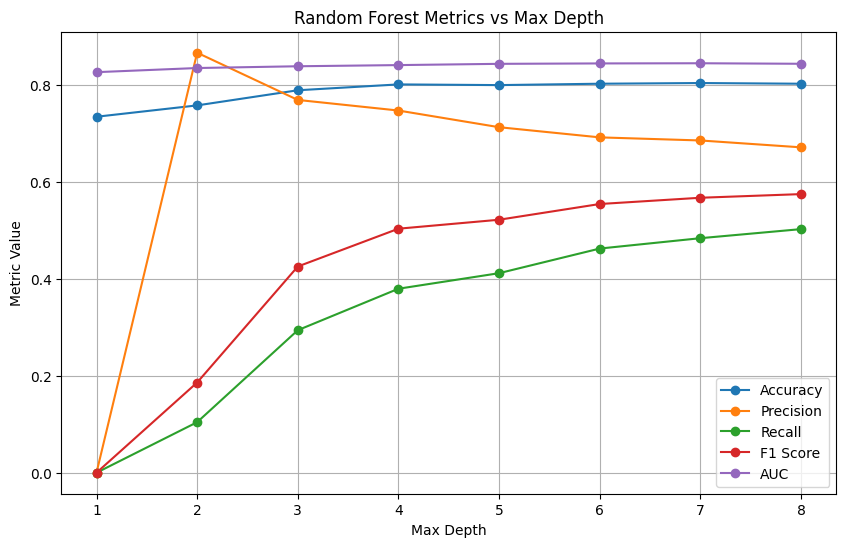

In [20]:
# plot metrics result
df_metrics = pd.DataFrame(metric_results)
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['max_depth'], df_metrics['accuracy'], marker='o', label='Accuracy')
plt.plot(df_metrics['max_depth'], df_metrics['precision'], marker='o', label='Precision')
plt.plot(df_metrics['max_depth'], df_metrics['recall'], marker='o', label='Recall')
plt.plot(df_metrics['max_depth'], df_metrics['f1'], marker='o', label='F1 Score')
plt.plot(df_metrics['max_depth'], df_metrics['auc'], marker='o', label='AUC')
plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.title('Random Forest Metrics vs Max Depth')
plt.legend()
plt.grid()
plt.show()

Try combination parameter max_depth and n_estimators

In [21]:
scores = []

for max_depth in [5, 10, 20]:
    for s in [100, 200, 500, 1000]:
        rf = train_rf(X_train, y_train, max_depth=max_depth, n_estimators=s)
        y_val_pred = rf.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_val_pred)

        scores.append((max_depth, s, auc_score))

In [22]:
columns = ['max_depth', 'n_estimators', 'auc_score']
df_scores = pd.DataFrame(scores, columns=columns)

In [23]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['auc_score'])
#df_scores_pivot.round(3)

In [24]:
df_scores

,max_depth,n_estimators,auc_score
0,5,100,0.843733
1,5,200,0.844288
2,5,500,0.844168
3,5,1000,0.844191
4,10,100,0.841187
5,10,200,0.840970
6,10,500,0.842236
7,10,1000,0.842422
8,20,100,0.825786
9,20,200,0.826743


In [25]:
df_scores_pivot

auc_score                    
max_depth           5         10        20
n_estimators                              
100           0.843733  0.841187  0.825786
200           0.844288  0.840970  0.826743
500           0.844168  0.842236  0.828610
1000          0.844191  0.842422  0.828458

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

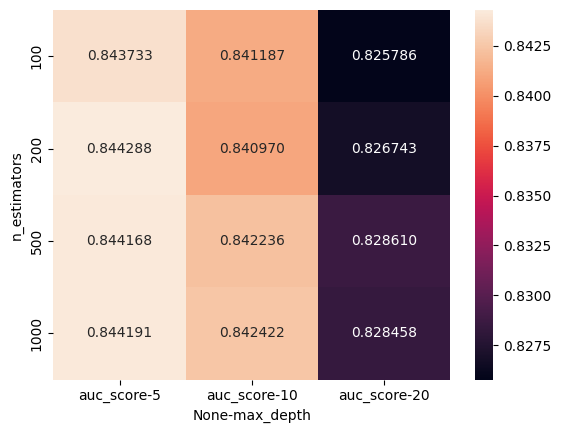

In [26]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".6f")

Base on the heatmap, choose max_depth=5 and n_estimator=200, it give highest auc 0.844288

## Cross validation with kfold

In [27]:
# combine train + val
#X_full_train = np.vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

In [28]:
# do cross validation

# convert arr_param to array of dict for readability
arr_param = [
    {'n_estimators': 200, 'max_depth': 5},
    {'n_estimators': 1000, 'max_depth': 5},
    {'n_estimators': 1000, 'max_depth': 10}
]

# Rebuild full-train raw dicts so the DictVectorizer can be fit inside each fold
df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

result_auc = []

for p in arr_param:
    #print(p)

    pipe = make_pipeline(
        DictVectorizer(sparse=False),
        RandomForestClassifier(max_depth=p['max_depth'], n_estimators=p['n_estimators'], random_state=NUMBER_SEED)
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=NUMBER_SEED)
    auc_scores = cross_val_score(pipe, X_full_train_dict, y_full_train, cv=cv, scoring='roc_auc')
    auc_mean = auc_scores.mean()
    auc_std = auc_scores.std()
    result_auc.append((p['max_depth'], p['n_estimators'], auc_mean, auc_std))



In [29]:
# Print result_auc in a table format
df_result_auc = pd.DataFrame(result_auc, columns=['max_depth', 'n_estimators','auc_mean', 'auc_std'])
print(df_result_auc)

   max_depth  n_estimators  auc_mean   auc_std
0          5           200  0.846231  0.006932
1          5          1000  0.846692  0.006702
2         10          1000  0.845125  0.006625


From cross validation result, max_depth=5 and n_estimators 200 and 1000 have small difference.



## Find best threshold

In [30]:
rf_best = train_rf(X_train, y_train, max_depth=5, n_estimators=200)
y_val_best_pred = rf_best.predict_proba(X_val)[:, 1]

In [31]:
thresholds = np.arange(0, 1.01, 0.01)

f1_scores = []
for t in thresholds:
    f1 = f1_score(y_val, y_val_best_pred > t)
    f1_scores.append(f1)
    #print(f'threshold={t:.2f} f1={f1:.4f}')
    
best_threshold = thresholds[np.argmax(f1_scores)]

print('Best threshold:', best_threshold)
print('Best f1 score:', max(f1_scores))

Best threshold: 0.33
Best f1 score: 0.6439135381114903


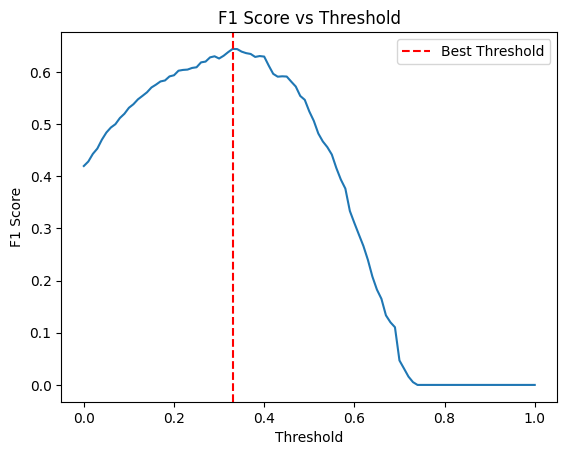

In [32]:
# plot f1 scores vs thresholds
plt.plot(thresholds, f1_scores)
# draw vertical line at best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

## Train final model

Train final model with train+val dataset, using parameter max_depth=5 and n_estimators=200.

And do prediction using test dataset.

In [33]:
# Final model using the same pipeline approach
final_pipe = make_pipeline(
    DictVectorizer(sparse=False),
    RandomForestClassifier(max_depth=5, n_estimators=200, random_state=NUMBER_SEED)
)

df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

final_pipe.fit(X_full_train_dict, y_full_train)


Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=1))])

In [34]:
# Predict on test
best_th = 0.33

X_test_dict = df_test.to_dict(orient='records')
y_test_pred = final_pipe.predict_proba(X_test_dict)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred)
f1 = f1_score(y_test, (y_test_pred >= best_th).astype(int))
print("auc test ",auc_test)
print("f1 test ",f1)

auc test  0.8352179079800562
f1 test  0.6259711431742508


Get top 10 Feature Importance

In [36]:
# Extract feature names and importances from the fitted pipeline
dv_final = final_pipe.named_steps['dictvectorizer']
tree_final = final_pipe.named_steps['randomforestclassifier']

df_fi = pd.DataFrame({
    'feature': dv_final.get_feature_names_out(),
    'importance': tree_final.feature_importances_
}).sort_values(by='importance', ascending=False)

# Top 10
df_fi.head(10)

,feature,importance
0,contract=month-to-month,0.150907
43,tenure,0.130297
20,onlinesecurity=no,0.105687
44,totalcharges,0.085550
11,internetservice=fiber_optic,0.079732
2,contract=two_year,0.066582
40,techsupport=no,0.062419
29,paymentmethod=electronic_check,0.056652
13,monthlycharges,0.037307
10,internetservice=dsl,0.027058


Plot Features Importance

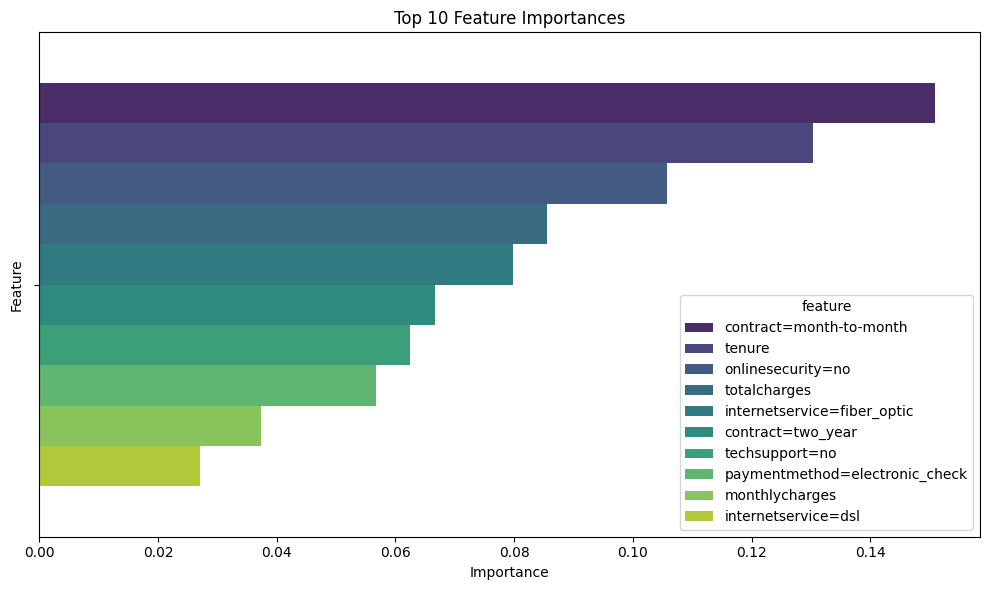

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    hue='feature',
    data=df_fi.head(10),
    palette='viridis'
)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Plot ROC curve on test dataset

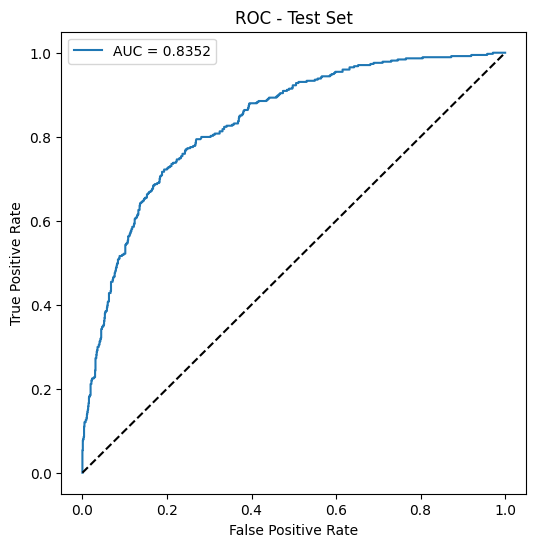

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend()
plt.show()
